In [1]:
# Import libraries
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Load the data from the CSV file
price_data = pd.read_csv('./data/CCL_historical_data.csv')
price_data

,datetime,o,h,l,c,v,readable_time
0,1514872800000,67.220,67.2600,66.6000,66.75,2784023,2018-01-02 00:00:00
1,1514959200000,66.740,67.1300,66.0600,66.90,2808203,2018-01-03 00:00:00
2,1515045600000,66.900,67.1100,66.4600,66.85,3050324,2018-01-04 00:00:00
3,1515132000000,67.000,67.1199,66.2000,66.30,3793549,2018-01-05 00:00:00
4,1515391200000,66.220,66.3000,65.9500,66.05,2027088,2018-01-08 00:00:00
...,...,...,...,...,...,...,...
616,1592197200000,18.140,19.8150,17.9500,19.44,59224492,2020-06-15 00:00:00
617,1592283600000,21.815,21.8500,19.6072,20.42,58679115,2020-06-16 00:00:00
618,1592370000000,19.320,19.7997,18.6700,19.09,44645686,2020-06-17 00:00:00
619,1592456400000,17.960,19.5450,17.8000,18.82,60188028,2020-06-18 00:00:00


In [3]:
# Add a "Change in price" column
price_data['change_in_price'] = price_data['c'].diff()

In [4]:
price_data.head()

,datetime,o,h,l,c,v,readable_time,change_in_price
0,1514872800000,67.22,67.2600,66.60,66.75,2784023,2018-01-02 00:00:00,NaN
1,1514959200000,66.74,67.1300,66.06,66.90,2808203,2018-01-03 00:00:00,0.15
2,1515045600000,66.90,67.1100,66.46,66.85,3050324,2018-01-04 00:00:00,-0.05
3,1515132000000,67.00,67.1199,66.20,66.30,3793549,2018-01-05 00:00:00,-0.55
4,1515391200000,66.22,66.3000,65.95,66.05,2027088,2018-01-08 00:00:00,-0.25


In [5]:
# Let's smooth out the data to remove some randomness and noise

# Define the number of frequency intervals you want to predict (in this case, 1 minute)
interval_out = 1 # Tomorrow

# Group by symbol, then apply the rolling function and grab the min/max
price_data_smoothed = price_data[['c','l','h','o','v']].transform(lambda x: x.ewm(span = interval_out).mean())
    
smoothed_df = pd.concat([price_data[['datetime','readable_time']], price_data_smoothed], axis = 1, sort=False)
smoothed_df

,datetime,readable_time,c,l,h,o,v
0,1514872800000,2018-01-02 00:00:00,66.75,66.6000,67.2600,67.220,2784023.0
1,1514959200000,2018-01-03 00:00:00,66.90,66.0600,67.1300,66.740,2808203.0
2,1515045600000,2018-01-04 00:00:00,66.85,66.4600,67.1100,66.900,3050324.0
3,1515132000000,2018-01-05 00:00:00,66.30,66.2000,67.1199,67.000,3793549.0
4,1515391200000,2018-01-08 00:00:00,66.05,65.9500,66.3000,66.220,2027088.0
...,...,...,...,...,...,...,...
616,1592197200000,2020-06-15 00:00:00,19.44,17.9500,19.8150,18.140,59224492.0
617,1592283600000,2020-06-16 00:00:00,20.42,19.6072,21.8500,21.815,58679115.0
618,1592370000000,2020-06-17 00:00:00,19.09,18.6700,19.7997,19.320,44645686.0
619,1592456400000,2020-06-18 00:00:00,18.82,17.8000,19.5450,17.960,60188028.0


In [6]:
smoothed_df['Signal_Flag'] = smoothed_df['datetime'].transform(lambda x: np.sign(x.diff(interval_out)))

smoothed_df.head(50)

,datetime,readable_time,c,l,h,o,v,Signal_Flag
0,1514872800000,2018-01-02 00:00:00,66.75,66.600,67.2600,67.22,2784023.0,NaN
1,1514959200000,2018-01-03 00:00:00,66.90,66.060,67.1300,66.74,2808203.0,1.0
2,1515045600000,2018-01-04 00:00:00,66.85,66.460,67.1100,66.90,3050324.0,1.0
3,1515132000000,2018-01-05 00:00:00,66.30,66.200,67.1199,67.00,3793549.0,1.0
4,1515391200000,2018-01-08 00:00:00,66.05,65.950,66.3000,66.22,2027088.0,1.0
5,1515477600000,2018-01-09 00:00:00,67.63,66.880,68.0200,67.13,3470382.0,1.0
6,1515564000000,2018-01-10 00:00:00,67.95,67.870,68.8800,68.19,3300864.0,1.0
7,1515650400000,2018-01-11 00:00:00,68.80,68.150,69.1400,68.83,2632409.0,1.0
8,1515736800000,2018-01-12 00:00:00,69.69,68.810,69.7200,68.98,3243963.0,1.0
9,1516082400000,2018-01-16 00:00:00,68.52,68.210,69.7300,69.40,3664020.0,1.0


In [7]:
# RSI

# Calculate 14 intervals (days)
n = 14
up_df, down_df = price_data[['datetime','change_in_price']].copy(), price_data[['datetime','change_in_price']].copy()

up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We can obly have positive values so change negative down days to their absolute value
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EQMA (Exponential Weighted Moving Average), meaning older values are given less weight compared
#  new values
ewma_up = up_df['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# # Calculate Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate Relative Strength Index (RSI)
relative_strength_index = 100.0 - (100 / (1.0 + relative_strength))

# Add data into the data frame
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = down_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.head()

,datetime,o,h,l,c,v,readable_time,change_in_price,down_days,up_days,RSI
0,1514872800000,67.22,67.2600,66.60,66.75,2784023,2018-01-02 00:00:00,NaN,NaN,NaN,NaN
1,1514959200000,66.74,67.1300,66.06,66.90,2808203,2018-01-03 00:00:00,0.15,0.00,0.00,100.000000
2,1515045600000,66.90,67.1100,66.46,66.85,3050324,2018-01-04 00:00:00,-0.05,0.05,0.05,72.222222
3,1515132000000,67.00,67.1199,66.20,66.30,3793549,2018-01-05 00:00:00,-0.55,0.55,0.55,15.958451
4,1515391200000,66.22,66.3000,65.95,66.05,2027088,2018-01-08 00:00:00,-0.25,0.25,0.25,11.329414


In [8]:
# Stochastic Oscillator
n = 25

low_25, high_25 = price_data[['datetime', 'l']].copy(), price_data[['datetime', 'h']].copy()

low_25 = low_25['l'].transform(lambda x: x.rolling(window = n).min())
high_25 = high_25['h'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator
k_percent = 100 * ((price_data['c'] - 14) / (high_25 - low_25))

# Add the info to the data frame
price_data['low_14'] = low_25
price_data['high_14'] = high_25
price_data['k_percent'] = k_percent

price_data.head(30)

,datetime,o,h,l,c,v,readable_time,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
0,1514872800000,67.22,67.2600,66.600,66.75,2784023,2018-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1514959200000,66.74,67.1300,66.060,66.90,2808203,2018-01-03 00:00:00,0.15,0.00,0.00,100.000000,NaN,NaN,NaN
2,1515045600000,66.90,67.1100,66.460,66.85,3050324,2018-01-04 00:00:00,-0.05,0.05,0.05,72.222222,NaN,NaN,NaN
3,1515132000000,67.00,67.1199,66.200,66.30,3793549,2018-01-05 00:00:00,-0.55,0.55,0.55,15.958451,NaN,NaN,NaN
4,1515391200000,66.22,66.3000,65.950,66.05,2027088,2018-01-08 00:00:00,-0.25,0.25,0.25,11.329414,NaN,NaN,NaN
5,1515477600000,67.13,68.0200,66.880,67.63,3470382,2018-01-09 00:00:00,1.58,0.00,0.00,71.536749,NaN,NaN,NaN
6,1515564000000,68.19,68.8800,67.870,67.95,3300864,2018-01-10 00:00:00,0.32,0.00,0.00,75.434672,NaN,NaN,NaN
7,1515650400000,68.83,69.1400,68.150,68.80,2632409,2018-01-11 00:00:00,0.85,0.00,0.00,82.697131,NaN,NaN,NaN
8,1515736800000,68.98,69.7200,68.810,69.69,3243963,2018-01-12 00:00:00,0.89,0.00,0.00,87.250812,NaN,NaN,NaN
9,1516082400000,69.40,69.7300,68.210,68.52,3664020,2018-01-16 00:00:00,-1.17,1.17,1.17,62.357734,NaN,NaN,NaN


In [9]:
# Calculate the Willams %R
n = 25


low_25, high_25 = price_data[['datetime', 'l']].copy(), price_data[['datetime', 'h']].copy()

low_25 = low_25['l'].transform(lambda x: x.rolling(window = n).min())
high_25 = high_25['h'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R
r_percent = ((high_25 - price_data['c']) / (high_25 - low_25)) * -100

price_data['r_percent'] = r_percent

price_data.head(30)

,datetime,o,h,l,c,v,readable_time,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
0,1514872800000,67.22,67.2600,66.600,66.75,2784023,2018-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1514959200000,66.74,67.1300,66.060,66.90,2808203,2018-01-03 00:00:00,0.15,0.00,0.00,100.000000,NaN,NaN,NaN,NaN
2,1515045600000,66.90,67.1100,66.460,66.85,3050324,2018-01-04 00:00:00,-0.05,0.05,0.05,72.222222,NaN,NaN,NaN,NaN
3,1515132000000,67.00,67.1199,66.200,66.30,3793549,2018-01-05 00:00:00,-0.55,0.55,0.55,15.958451,NaN,NaN,NaN,NaN
4,1515391200000,66.22,66.3000,65.950,66.05,2027088,2018-01-08 00:00:00,-0.25,0.25,0.25,11.329414,NaN,NaN,NaN,NaN
5,1515477600000,67.13,68.0200,66.880,67.63,3470382,2018-01-09 00:00:00,1.58,0.00,0.00,71.536749,NaN,NaN,NaN,NaN
6,1515564000000,68.19,68.8800,67.870,67.95,3300864,2018-01-10 00:00:00,0.32,0.00,0.00,75.434672,NaN,NaN,NaN,NaN
7,1515650400000,68.83,69.1400,68.150,68.80,2632409,2018-01-11 00:00:00,0.85,0.00,0.00,82.697131,NaN,NaN,NaN,NaN
8,1515736800000,68.98,69.7200,68.810,69.69,3243963,2018-01-12 00:00:00,0.89,0.00,0.00,87.250812,NaN,NaN,NaN,NaN
9,1516082400000,69.40,69.7300,68.210,68.52,3664020,2018-01-16 00:00:00,-1.17,1.17,1.17,62.357734,NaN,NaN,NaN,NaN


In [10]:
#  Calculate MACD 
ema_26 = price_data['c'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data['c'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data fram
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

price_data.head(30)

,datetime,o,h,l,c,v,readable_time,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
0,1514872800000,67.22,67.2600,66.600,66.75,2784023,2018-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,1514959200000,66.74,67.1300,66.060,66.90,2808203,2018-01-03 00:00:00,0.15,0.00,0.00,100.000000,NaN,NaN,NaN,NaN,0.003365,0.001870
2,1515045600000,66.90,67.1100,66.460,66.85,3050324,2018-01-04 00:00:00,-0.05,0.05,0.05,72.222222,NaN,NaN,NaN,NaN,0.002738,0.002225
3,1515132000000,67.00,67.1199,66.200,66.30,3793549,2018-01-05 00:00:00,-0.55,0.55,0.55,15.958451,NaN,NaN,NaN,NaN,-0.017472,-0.004447
4,1515391200000,66.22,66.3000,65.950,66.05,2027088,2018-01-08 00:00:00,-0.25,0.25,0.25,11.329414,NaN,NaN,NaN,NaN,-0.038035,-0.014439
5,1515477600000,67.13,68.0200,66.880,67.63,3470382,2018-01-09 00:00:00,1.58,0.00,0.00,71.536749,NaN,NaN,NaN,NaN,0.017881,-0.005678
6,1515564000000,68.19,68.8800,67.870,67.95,3300864,2018-01-10 00:00:00,0.32,0.00,0.00,75.434672,NaN,NaN,NaN,NaN,0.067929,0.012950
7,1515650400000,68.83,69.1400,68.150,68.80,2632409,2018-01-11 00:00:00,0.85,0.00,0.00,82.697131,NaN,NaN,NaN,NaN,0.140822,0.043680
8,1515736800000,68.98,69.7200,68.810,69.69,3243963,2018-01-12 00:00:00,0.89,0.00,0.00,87.250812,NaN,NaN,NaN,NaN,0.233312,0.087486
9,1516082400000,69.40,69.7300,68.210,68.52,3664020,2018-01-16 00:00:00,-1.17,1.17,1.17,62.357734,NaN,NaN,NaN,NaN,0.235262,0.120596


In [11]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price and store it
price_data['Price_Rate_Of_Change'] = price_data['c'].transform(lambda x: x.pct_change(periods = n))

price_data.head(30)

,datetime,o,h,l,c,v,readable_time,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,1514872800000,67.22,67.2600,66.600,66.75,2784023,2018-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,1514959200000,66.74,67.1300,66.060,66.90,2808203,2018-01-03 00:00:00,0.15,0.00,0.00,100.000000,NaN,NaN,NaN,NaN,0.003365,0.001870,NaN
2,1515045600000,66.90,67.1100,66.460,66.85,3050324,2018-01-04 00:00:00,-0.05,0.05,0.05,72.222222,NaN,NaN,NaN,NaN,0.002738,0.002225,NaN
3,1515132000000,67.00,67.1199,66.200,66.30,3793549,2018-01-05 00:00:00,-0.55,0.55,0.55,15.958451,NaN,NaN,NaN,NaN,-0.017472,-0.004447,NaN
4,1515391200000,66.22,66.3000,65.950,66.05,2027088,2018-01-08 00:00:00,-0.25,0.25,0.25,11.329414,NaN,NaN,NaN,NaN,-0.038035,-0.014439,NaN
5,1515477600000,67.13,68.0200,66.880,67.63,3470382,2018-01-09 00:00:00,1.58,0.00,0.00,71.536749,NaN,NaN,NaN,NaN,0.017881,-0.005678,NaN
6,1515564000000,68.19,68.8800,67.870,67.95,3300864,2018-01-10 00:00:00,0.32,0.00,0.00,75.434672,NaN,NaN,NaN,NaN,0.067929,0.012950,NaN
7,1515650400000,68.83,69.1400,68.150,68.80,2632409,2018-01-11 00:00:00,0.85,0.00,0.00,82.697131,NaN,NaN,NaN,NaN,0.140822,0.043680,NaN
8,1515736800000,68.98,69.7200,68.810,69.69,3243963,2018-01-12 00:00:00,0.89,0.00,0.00,87.250812,NaN,NaN,NaN,NaN,0.233312,0.087486,NaN
9,1516082400000,69.40,69.7300,68.210,68.52,3664020,2018-01-16 00:00:00,-1.17,1.17,1.17,62.357734,NaN,NaN,NaN,NaN,0.235262,0.120596,0.026517


In [12]:
def on_balance_volume(stock):
    
    # Grab the volume and close colum
    volume = stock['v']
    change = stock['c'].diff()
    
    # Initialize the previous OBV
    prev_obv = 0
    obv_values = []
    
    # Calculate the On Balance Volume
    for i, j in zip(change, volume):
        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv
            
        prev_obv = current_obv
        obv_values.append(current_obv)
        
    # Return a panda series
    return pd.Series(obv_values, index = stock.index)


# Apply the function
obv = on_balance_volume(price_data)

# Add to the data frame but drop the old index before adding it
price_data['On Balance Volume'] = obv.reset_index(level = 0, drop = True)

price_data.head(30)

,datetime,o,h,l,c,v,readable_time,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
0,1514872800000,67.22,67.2600,66.600,66.75,2784023,2018-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0
1,1514959200000,66.74,67.1300,66.060,66.90,2808203,2018-01-03 00:00:00,0.15,0.00,0.00,100.000000,NaN,NaN,NaN,NaN,0.003365,0.001870,NaN,2808203
2,1515045600000,66.90,67.1100,66.460,66.85,3050324,2018-01-04 00:00:00,-0.05,0.05,0.05,72.222222,NaN,NaN,NaN,NaN,0.002738,0.002225,NaN,-242121
3,1515132000000,67.00,67.1199,66.200,66.30,3793549,2018-01-05 00:00:00,-0.55,0.55,0.55,15.958451,NaN,NaN,NaN,NaN,-0.017472,-0.004447,NaN,-4035670
4,1515391200000,66.22,66.3000,65.950,66.05,2027088,2018-01-08 00:00:00,-0.25,0.25,0.25,11.329414,NaN,NaN,NaN,NaN,-0.038035,-0.014439,NaN,-6062758
5,1515477600000,67.13,68.0200,66.880,67.63,3470382,2018-01-09 00:00:00,1.58,0.00,0.00,71.536749,NaN,NaN,NaN,NaN,0.017881,-0.005678,NaN,-2592376
6,1515564000000,68.19,68.8800,67.870,67.95,3300864,2018-01-10 00:00:00,0.32,0.00,0.00,75.434672,NaN,NaN,NaN,NaN,0.067929,0.012950,NaN,708488
7,1515650400000,68.83,69.1400,68.150,68.80,2632409,2018-01-11 00:00:00,0.85,0.00,0.00,82.697131,NaN,NaN,NaN,NaN,0.140822,0.043680,NaN,3340897
8,1515736800000,68.98,69.7200,68.810,69.69,3243963,2018-01-12 00:00:00,0.89,0.00,0.00,87.250812,NaN,NaN,NaN,NaN,0.233312,0.087486,NaN,6584860
9,1516082400000,69.40,69.7300,68.210,68.52,3664020,2018-01-16 00:00:00,-1.17,1.17,1.17,62.357734,NaN,NaN,NaN,NaN,0.235262,0.120596,0.026517,2920840


In [13]:
# Hooray! Finallly building the model!

# Create the column we wish to predict

# Close colum
close_column = price_data['c']

# Apply lambda function which will return -1.0 for down, 1.0 for up, 0.0 for no change
close_column = close_column.transform(lambda x: np.where(x.diff() > 0, 1.0, -1.0))

price_data['Prediction'] = close_column

price_data.tail(15)

,datetime,o,h,l,c,v,readable_time,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
606,1590987600000,15.980,17.0800,15.8700,16.80,42635527,2020-06-01 00:00:00,1.06,0.00,0.00,65.882464,11.00,18.160,39.106145,-18.994413,0.582453,0.190570,0.141304,405443060,1.0
607,1591074000000,17.330,17.4800,16.5600,16.87,41632085,2020-06-02 00:00:00,0.07,0.00,0.00,66.329613,11.00,18.160,40.083799,-18.016760,0.665187,0.285494,0.195606,447075145,1.0
608,1591160400000,16.710,17.6500,16.5700,17.25,53113165,2020-06-03 00:00:00,0.38,0.00,0.00,68.884025,11.00,18.160,45.391061,-12.709497,0.752739,0.378943,0.219081,500188310,1.0
609,1591246800000,17.360,19.0550,16.6600,18.48,86050104,2020-06-04 00:00:00,1.23,0.00,0.00,75.753967,11.00,19.055,55.617629,-7.138423,0.910876,0.485329,0.265753,586238414,1.0
610,1591333200000,22.300,22.9400,21.0550,21.51,113521075,2020-06-05 00:00:00,3.03,0.00,0.00,85.102831,11.00,22.940,62.897822,-11.976549,1.266102,0.641484,0.487552,699759489,1.0
611,1591592400000,24.570,25.2750,23.4121,24.91,107262909,2020-06-08 00:00:00,3.40,0.00,0.00,90.063466,11.00,25.275,76.427320,-2.556918,1.801209,0.873429,0.530098,807022398,1.0
612,1591678800000,23.880,23.9000,21.9300,23.04,72547437,2020-06-09 00:00:00,-1.87,1.87,1.87,74.351401,11.00,25.275,63.327496,-15.656743,2.050752,1.108893,0.336427,734474961,-1.0
613,1591765200000,22.200,22.4700,19.5000,20.59,82883080,2020-06-10 00:00:00,-2.45,2.45,2.45,58.834950,11.00,25.275,46.164623,-32.819615,2.027451,1.292605,0.292530,651591881,-1.0
614,1591851600000,17.290,18.9900,16.7500,17.44,79106599,2020-06-11 00:00:00,-3.15,3.15,3.15,44.926024,11.00,25.275,24.098074,-54.886165,1.734808,1.381045,0.108005,572485282,-1.0
615,1591938000000,19.810,20.2000,18.5300,19.98,65140117,2020-06-12 00:00:00,2.54,0.00,0.00,54.855646,11.00,25.275,41.891419,-37.092820,1.688381,1.442512,0.189286,637625399,1.0


In [14]:
# Need to remove NaN values because Random Forest can't accept them

print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Drop any rows that have 'Nan' value in them
price_data = price_data.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

price_data.head()

Before NaN Drop we have 621 rows and 20 columns
After NaN Drop we have 597 rows and 20 columns


,datetime,o,h,l,c,v,readable_time,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
24,1517896800000,67.43,69.450,66.770,69.27,4476034,2018-02-06 00:00:00,1.23,0.00,0.00,44.814485,65.950,72.7,818.814815,-50.814815,0.285279,0.478384,-0.026697,-1999820,1.0
25,1517983200000,68.61,69.954,68.380,69.12,3122572,2018-02-07 00:00:00,-0.15,0.15,0.15,43.647099,65.950,72.7,816.592593,-53.037037,0.200754,0.422690,-0.023177,-5122392,-1.0
26,1518069600000,69.59,69.600,66.750,66.76,3683577,2018-02-08 00:00:00,-2.36,2.36,2.36,29.633544,65.950,72.7,781.629630,-88.000000,-0.034731,0.330984,-0.068248,-8805969,-1.0
27,1518156000000,67.30,67.620,64.801,67.07,5188931,2018-02-09 00:00:00,0.31,0.00,0.00,32.898826,64.801,72.7,671.857197,-71.274845,-0.195774,0.225428,-0.067695,-3617038,1.0
28,1518415200000,67.57,68.950,67.560,68.77,3145990,2018-02-12 00:00:00,1.70,0.00,0.00,48.129267,64.801,72.7,693.378909,-49.753133,-0.196601,0.140892,-0.042067,-471048,1.0


In [15]:
# Time to split the data into training and test sets

'''
The following will be our input columns:
- RSI
- Stochastic Oscillator
- William %R
- Price Rate of Change
- MACD

The input columns will be out X and the Y will be the Prediction column
'''

# Grab out X & Y columsn
X_Cols = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split and and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_forest_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_forest_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_forest_clf.predict(X_test)
print("Prediction:")
y_pred

Prediction:


array([-1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1., -1., -1.,
        1.,  1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1.,
        1., -1., -1., -1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1.,
        1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,
       -1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,
        1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,
        1.,  1.,  1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.,  1.,
       -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.,
       -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,
        1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1., -1.])

In [16]:
# Print the accuracy of our model
print('Correct Prediction (%)', accuracy_score(y_test, rand_forest_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%) 64.0


In [17]:
# Interpreting the Classification Report
target_names = ['Down Day', 'Up Day']

# Build a classification report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to data fram, transpose for readability
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.656716,0.586667,0.619718,75.00
Up Day,0.626506,0.693333,0.658228,75.00
accuracy,0.640000,0.640000,0.640000,0.64
macro avg,0.641611,0.640000,0.638973,150.00
weighted avg,0.641611,0.640000,0.638973,150.00


array([[44, 31],
       [23, 52]])

Accuracy: 0.64
Percision: 0.6265060240963856
Recall: 0.6933333333333334
Specificity: 0.5866666666666667


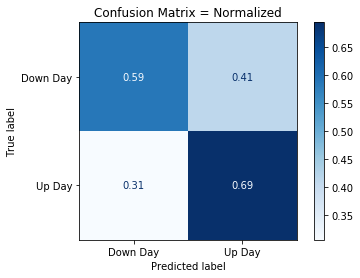

In [18]:
# Model evaluation: Confusion matrix

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

display(rf_matrix)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rand_forest_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix = Normalized')
plt.show()

In [19]:
# Calculate the feature importance

# Gini-Based importance
feature_imp = pd.Series(rand_forest_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

r_percent               0.219077
RSI                     0.217416
Price_Rate_Of_Change    0.156185
MACD                    0.152716
k_percent               0.129912
On Balance Volume       0.124694
dtype: float64

Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

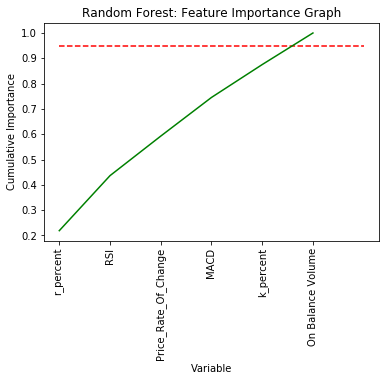

In [20]:
# Feature importance graphing

# Sotre the values in a list to plot
x_values = list(range(len(rand_forest_clf.feature_importances_)))

# Cumulative importances
cumulative_importances = np.cumsum(feature_imp.values)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(feature_imp), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, feature_imp.index, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')

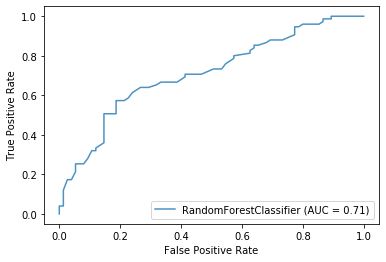

In [21]:
# ROC (Receiver Operating Characteristic). Used for evaluating the performance of a binary classifier.
# ROC curves are used to select the optimal model and discard the suboptimal ones

# Create an ROC Curve plot
rfc_disp = plot_roc_curve(rand_forest_clf, X_test, y_test, alpha=0.8)
plt.show()

In [22]:
# Out-Of-Bag (OOB) Error Score

print('Random Forest Out-Of-Bag Error Score: {}'.format(rand_forest_clf.oob_score_))

Random Forest Out-Of-Bag Error Score: 0.6845637583892618


In [23]:
# Randomized Search

# Number of trees in random forest
# Number of trees is not a parameter that should be tuned but just set large enough. There is no risk of overfitting in random forest with growing number of trees,
#  as they are trained independently of each other
n_estimators = list(range(200, 2000, 200))

# Number of features to consider at every split
max_features = ['auto', 'sqrt', None, 'log2']

# Maximum number of levels in the tree
# Max depth is a paramter that most of the time should be set as high as possible but, may be set lower if it achieves better performance
max_depth = list(range(10, 110, 10))
max_depth.append(None)

# Minimum number of levels in tree
# Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
#  Too high values can alos lead to under-fitting. Hence, you can tune the values for min_samples_split depending on the level of underfitting/overfitting
min_samples_split = [2, 5, 10, 20, 30, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 7, 12, 14, 16, 20]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [24]:
# Now that we have a range of values for our hyper parameters, we can put them to the test

# New Random Forest Classifier to house optimal paramters
rf = RandomForestClassifier()

# Speicify the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.4min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt', None,
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 7, 12, 14,
                                                             16, 20],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
          

In [25]:
# With the new Random Classifier trained, we can proceed to our regular steps, prediction
y_prediction = rf_random.predict(X_test)
print(y_pred)

'''
    Accuracy
'''
# Once the predictions have been made then grab the accuracy score
print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize=True) * 100.0)

'''
    CLASSIFICATION REPORT
'''
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')

'''
    FEATURE IMPORTANCE
'''
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_forest_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
display(feature_imp)

[-1.  1. -1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1. -1. -1.
 -1.  1. -1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1. -1.  1.  1. -1.
  1. -1.  1.  1. -1. -1. -1. -1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1.
  1. -1.  1.  1. -1.  1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1. -1.
 -1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1.  1. -1.
 -1.  1.  1.  1. -1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1.  1.  1.  1.
 -1.  1.  1.  1. -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.
 -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1.  1. -1.  1.  1.  1.
  1.  1.  1.  1. -1. -1.]
Correct Prediction (%):  62.66666666666667


,precision,recall,f1-score,support
Down Day,0.656716,0.586667,0.619718,75.00
Up Day,0.626506,0.693333,0.658228,75.00
accuracy,0.640000,0.640000,0.640000,0.64
macro avg,0.641611,0.640000,0.638973,150.00
weighted avg,0.641611,0.640000,0.638973,150.00


r_percent               0.219077
RSI                     0.217416
Price_Rate_Of_Change    0.156185
MACD                    0.152716
k_percent               0.129912
On Balance Volume       0.124694
dtype: float64

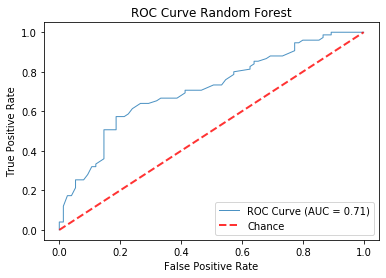

In [26]:
'''
    ROC CURVE
'''

fig, ax = plt.subplots()

# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rand_forest_clf, X_test, y_test, alpha = 0.8, name='ROC Curve', lw=1, ax=ax)

# Add our Chance Line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Make it look pretty.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

# Add the legend to the plot
ax.legend(loc="lower right")

plt.show()